# ENVIRONMENT SETUP

In [1]:
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
import gymnasium as gym
import torch.optim as optim
from collections import deque 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from __future__ import annotations
from collections import defaultdict

import math
# Environment setup
env = gym.make('Blackjack-v1', sab=True)

# DQN AND AGENT DEFINITION

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, defaultdict
import random
from tqdm import tqdm
import gymnasium as gym


In [ ]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)


In [4]:

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)


In [5]:

# DQN Agent with Experience Replay
class DQNAgent:
    def __init__(
        self,
        env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
        batch_size: int = 64,
        buffer_capacity: int = 10000,
        target_update_frequency: int = 100,
    ):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.state_dim = 3  # player_sum, dealer_card, usable_ace
        self.action_dim = env.action_space.n
        
        # Initialize networks
        self.policy_net = DQN(self.state_dim, self.action_dim).to(self.device)
        self.target_net = DQN(self.state_dim, self.action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.replay_buffer = ReplayBuffer(buffer_capacity)
        self.batch_size = batch_size
        self.target_update_frequency = target_update_frequency
        self.steps = 0
        
        # Epsilon parameters
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.discount_factor = discount_factor
        
        # Training tracking
        self.training_error = []

    def _state_to_tensor(self, state):
        player_sum, dealer_card, usable_ace = state
        return torch.tensor([
            player_sum / 31.0,  # Normalized player sum
            dealer_card / 10.0,  # Normalized dealer card
            1.0 if usable_ace else 0.0
        ], dtype=torch.float32, device=self.device)

    def get_action(self, env, obs: tuple[int, int, bool]) -> int:
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            with torch.no_grad():
                state_tensor = self._state_to_tensor(obs).unsqueeze(0)
                q_values = self.policy_net(state_tensor)
                return q_values.argmax().item()

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        # Store experience in replay buffer
        self.replay_buffer.add(obs, action, reward, next_obs, terminated)
        
        if len(self.replay_buffer) < self.batch_size:
            return
        
        # Sample batch from buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        # Convert to tensors
        state_tensors = torch.stack([self._state_to_tensor(s) for s in states]).to(self.device)
        action_tensors = torch.tensor(actions, dtype=torch.long, device=self.device).unsqueeze(1)
        reward_tensors = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        next_state_tensors = torch.stack([self._state_to_tensor(ns) for ns in next_states]).to(self.device)
        done_tensors = torch.tensor(dones, dtype=torch.float32, device=self.device)
        
        # Calculate current Q-values
        current_q = self.policy_net(state_tensors).gather(1, action_tensors)
        
        # Calculate target Q-values
        with torch.no_grad():
            next_q = self.target_net(next_state_tensors).max(1)[0]
        target_q = reward_tensors + (1 - done_tensors) * self.discount_factor * next_q
        target_q = target_q.unsqueeze(1)
        
        # Compute loss
        loss = nn.MSELoss()(current_q, target_q)
        self.training_error.append(loss.item())
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network
        self.steps += 1
        if self.steps % self.target_update_frequency == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


In [ ]:

# Environment setup
env = gym.make("Blackjack-v1", sab=True)

# Hyperparameters
n_episodes = 1_000_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.01
buffer_capacity = 10000
target_update_frequency = 100
learning_rate = 3e-4  # Increased from 1e-4
batch_size = 128       # Increased from 64
discount_factor = 0.99 # Increased from 0.95

# Initialize agent
agent = DQNAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount_factor,
    batch_size=batch_size,
    buffer_capacity=buffer_capacity,
    target_update_frequency=target_update_frequency
)


In [7]:

# Training loop
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    
    while not done:
        action = agent.get_action(env, obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        agent.update(obs, action, reward, terminated, next_obs)
        
        done = terminated or truncated
        obs = next_obs
    
    agent.decay_epsilon()

100%|██████████| 1000000/1000000 [9:48:39<00:00, 28.31it/s]  


CANCELLA QUESTA CELLA SOTTO

In [ ]:
moving_avg = np.convolve(agent.training_error, np.ones(50000)/50000, mode='valid')

# Detect convergence parameters
window_size = 100          # Check stability over 100 windows (5M steps)
threshold_std = 0.0001      # Maximum allowed standard deviation
threshold_mean = 0.001      # Maximum absolute mean to consider "near convergence"
min_consecutive = 50       # Require 50 consecutive stable windows (~2.5M steps)

# Calculate rolling statistics
rolling_mean = pd.Series(moving_avg).rolling(window_size).mean().values
rolling_std = pd.Series(moving_avg).rolling(window_size).std().values

# Create mask for convergence criteria
mask = (
    (rolling_std < threshold_std) & 
    (np.abs(rolling_mean) < threshold_mean) &
    (~np.isnan(rolling_std))  # Ignore NaN values
)



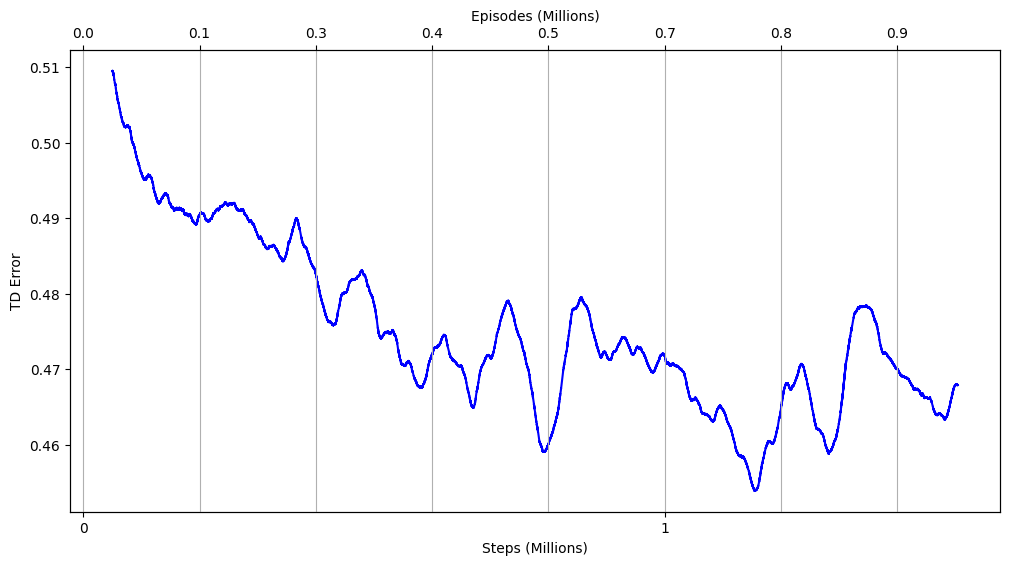

In [19]:
x_values = (np.arange(len(moving_avg)) + 50000) / 1e6  # Steps in millions

# Calculate average steps per episode
n_episodes = 1_000_000  # From your training setup
total_steps = len(agent.training_error)
avg_steps_per_episode = total_steps / n_episodes

# Create plot with dual x-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(x_values, moving_avg, label='TD Error (50k avg)', color='blue')

# Primary x-axis (steps)
ax1.set_xlabel('Steps (Millions)')
ax1.set_ylabel('TD Error')
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

# Secondary x-axis (episodes)
ax2 = ax1.twiny()
ax2.set_xlabel('Episodes (Millions)')
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(
    lambda x, _: f'{x / avg_steps_per_episode:.1f}'))  # Convert steps to episodes
ax2.set_xlim(ax1.get_xlim())

plt.grid(True)
plt.show()

In [20]:
reward_avg = np.convolve(env.return_queue, np.ones(50000)/50000, mode='valid')

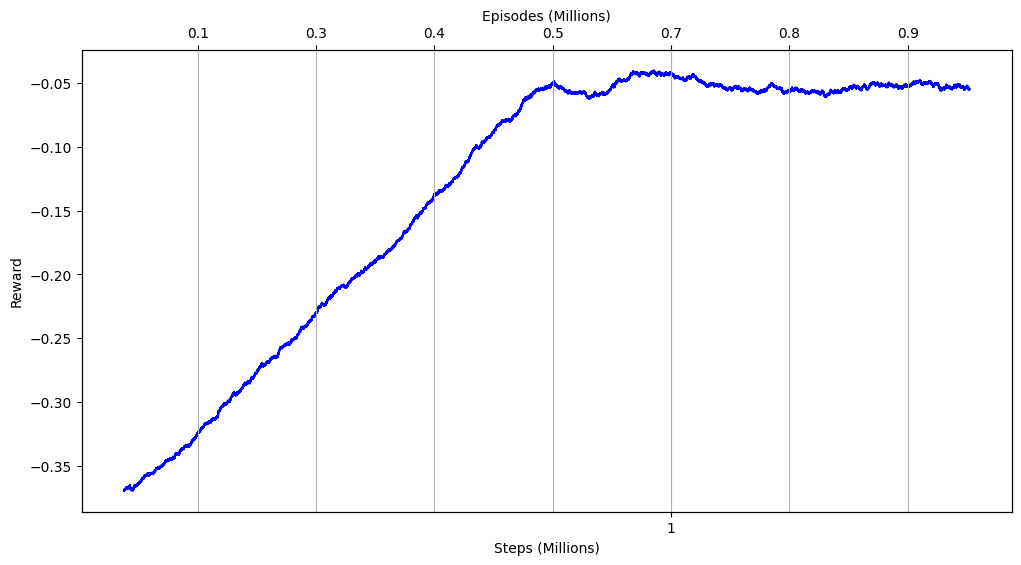

In [21]:
# Calculate total steps and episodes
total_steps = len(agent.training_error)  # From TD error data
n_episodes_total = len(env.return_queue)  # Total episodes
avg_steps_per_episode = total_steps / n_episodes_total

# X-values in steps (convert episode index to steps)
x_values_steps = ((np.arange(len(reward_avg)) + 50000) * avg_steps_per_episode) / 1e6  # Steps in millions

# Create plot
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(x_values_steps, reward_avg, label='Reward (50k avg)', color='blue')

# Primary x-axis (steps at bottom)
ax1.set_xlabel('Steps (Millions)')
ax1.set_ylabel('Reward')
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Steps in 1M increments

# Secondary x-axis (episodes at top)
ax2 = ax1.twiny()
ax2.set_xlabel('Episodes (Millions)')
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(
    lambda x, _: f'{x / avg_steps_per_episode:.1f}'))  # Convert steps to episodes
ax2.set_xlim(ax1.get_xlim())  # Match limits with primary axis

plt.grid(True)
plt.show()

In [28]:
last_entries = list(env.return_queue)[-200000:]

# Calculate the average of the last 200k entries
average = np.mean(last_entries)

In [29]:
average

-0.053715

In [26]:
import itertools

n_ultima = 1

inizio = n_ultima*50000
fine = (n_ultima-1)*50000

sum(list(itertools.islice(env.return_queue, len(env.return_queue)-inizio, len(env.return_queue)-fine)))/50000

-0.0549

In [ ]:
import pandas as pd

#Create the policy matrix, for sums 12-21, dealer card 1-10, usable ace = No
policy = np.zeros((11, 10))
for player_sum in range(12, 22):
    for dealer_card in range(1, 11):
        state_tensor = agent._state_to_tensor([player_sum, dealer_card, 0]).unsqueeze(0)
        # Get action from policy network (no epsilon exploration)
        with torch.no_grad():
            q_values = agent.policy_net(state_tensor)
            action = q_values.argmax().item()
        policy[player_sum - 12, dealer_card - 1] = action
#Make it a df with the right index and columns
policy = pd.DataFrame(policy, index=range(11, 22), columns=range(1, 11))



#Reindexing
#rename column 1 to 'A'
policy.rename(columns={1: 'A'}, inplace=True)

# Reordering columns (excluding 'A' and placing it at the end)
columns_order = [col for col in policy.columns if col != 'A'] + ['A']
rows_order = range(21,10, -1)
policy = policy.reindex(rows_order)
policy = policy[columns_order]
annot_df = policy.replace({0.0: 'S', 1.0: 'H'})


In [ ]:
#write policy to csv
annot_df.to_csv('policies/hard/dqn.csv', index=True, header=True)

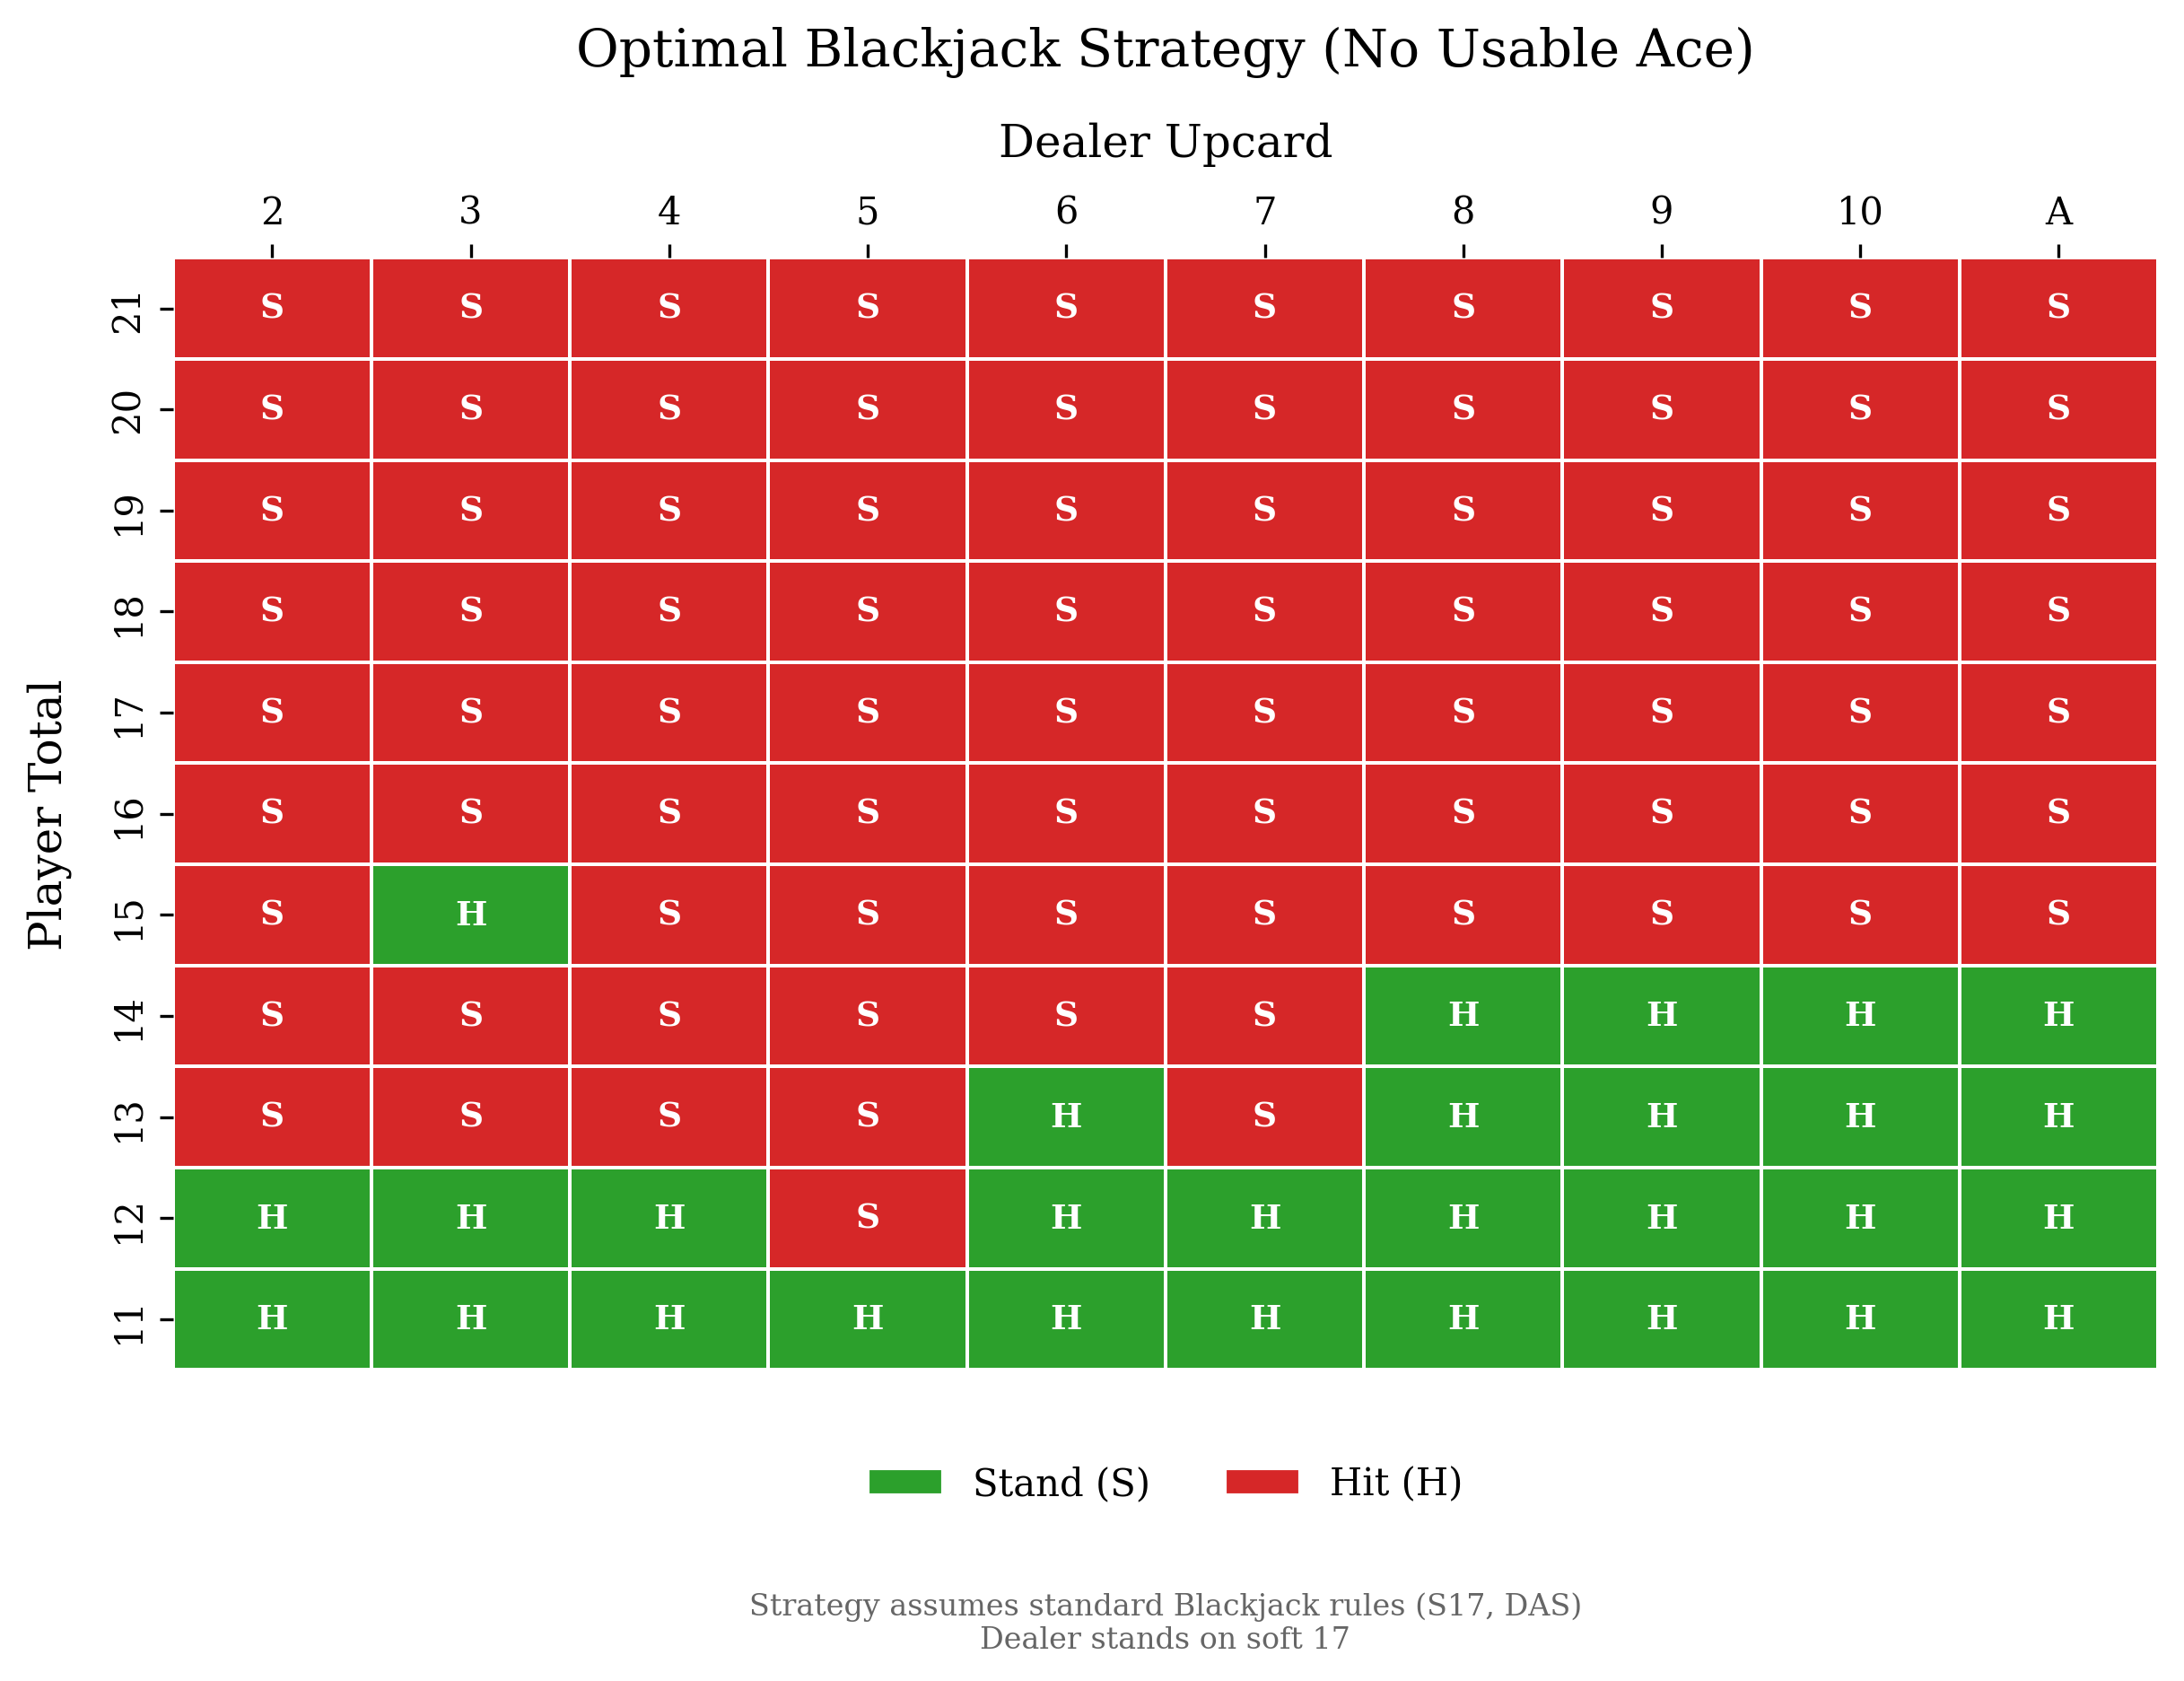

In [41]:
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

# Custom styling parameters
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'font.family': 'serif'
})

# Create figure with constrained layout
fig = plt.figure(figsize=(8, 6), dpi=300, layout='constrained')
ax = fig.add_subplot(111)

# Create custom colormap - CORRECTED SYNTAX
cmap = mcolors.ListedColormap(['#d62728', '#2ca02c'])  # Green for hit, red for stand
annot_df = policy.replace({0.0: 'S', 1.0: 'H'})

# Enhanced heatmap with styling
sns.heatmap(
    policy,
    cmap=cmap,
    annot=annot_df,
    fmt='',
    cbar=False,
    linewidths=0.5,
    linecolor='white',
    annot_kws={'fontsize': 9, 'color': 'white', 'weight': 'bold'},
    ax=ax
)


# Axis formatting
ax.set_xlabel("Dealer Upcard", labelpad=10)
ax.set_ylabel("Player Total", labelpad=10)
ax.set_title("Optimal Blackjack Strategy (No Usable Ace)", pad=15)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

# Custom legend
legend_elements = [
    Patch(facecolor='#2ca02c', edgecolor='white', label='Stand (S)'),
    Patch(facecolor='#d62728', edgecolor='white', label='Hit (H)')
]
ax.legend(
    handles=legend_elements,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False,
    fontsize=10
)

# Contextual annotation
ax.text(
    0.5, -0.25, 
    "Strategy assumes standard Blackjack rules (S17, DAS)\nDealer stands on soft 17",
    transform=ax.transAxes,
    ha='center',
    fontsize=8,
    color='#666666'
)

# Adjust layout and save
plt.show()

In [45]:
import pandas as pd

#Create the policy matrix, for sums 12-21, dealer card 1-10, usable ace = No
policy = np.zeros((11, 10))
for player_sum in range(12, 22):
    for dealer_card in range(1, 11):
        state_tensor = agent._state_to_tensor([player_sum, dealer_card, 1]).unsqueeze(0)
        # Get action from policy network (no epsilon exploration)
        with torch.no_grad():
            q_values = agent.policy_net(state_tensor)
            action = q_values.argmax().item()
        policy[player_sum - 12, dealer_card - 1] = action
#Make it a df with the right index and columns
policy = pd.DataFrame(policy, index=range(11, 22), columns=range(1, 11))




#Reindexing
#rename column 1 to 'A'
policy.rename(columns={1: 'A'}, inplace=True)

# Reordering columns (excluding 'A' and placing it at the end)
columns_order = [col for col in policy.columns if col != 'A'] + ['A']
rows_order = range(21,10, -1)
policy = policy.reindex(rows_order)
policy = policy[columns_order]

annot_df = policy.replace({0.0: 'S', 1.0: 'H'})


In [ ]:
#write policy to csv
annot_df.to_csv('policies/soft/dqn.csv', index=True, header=True)

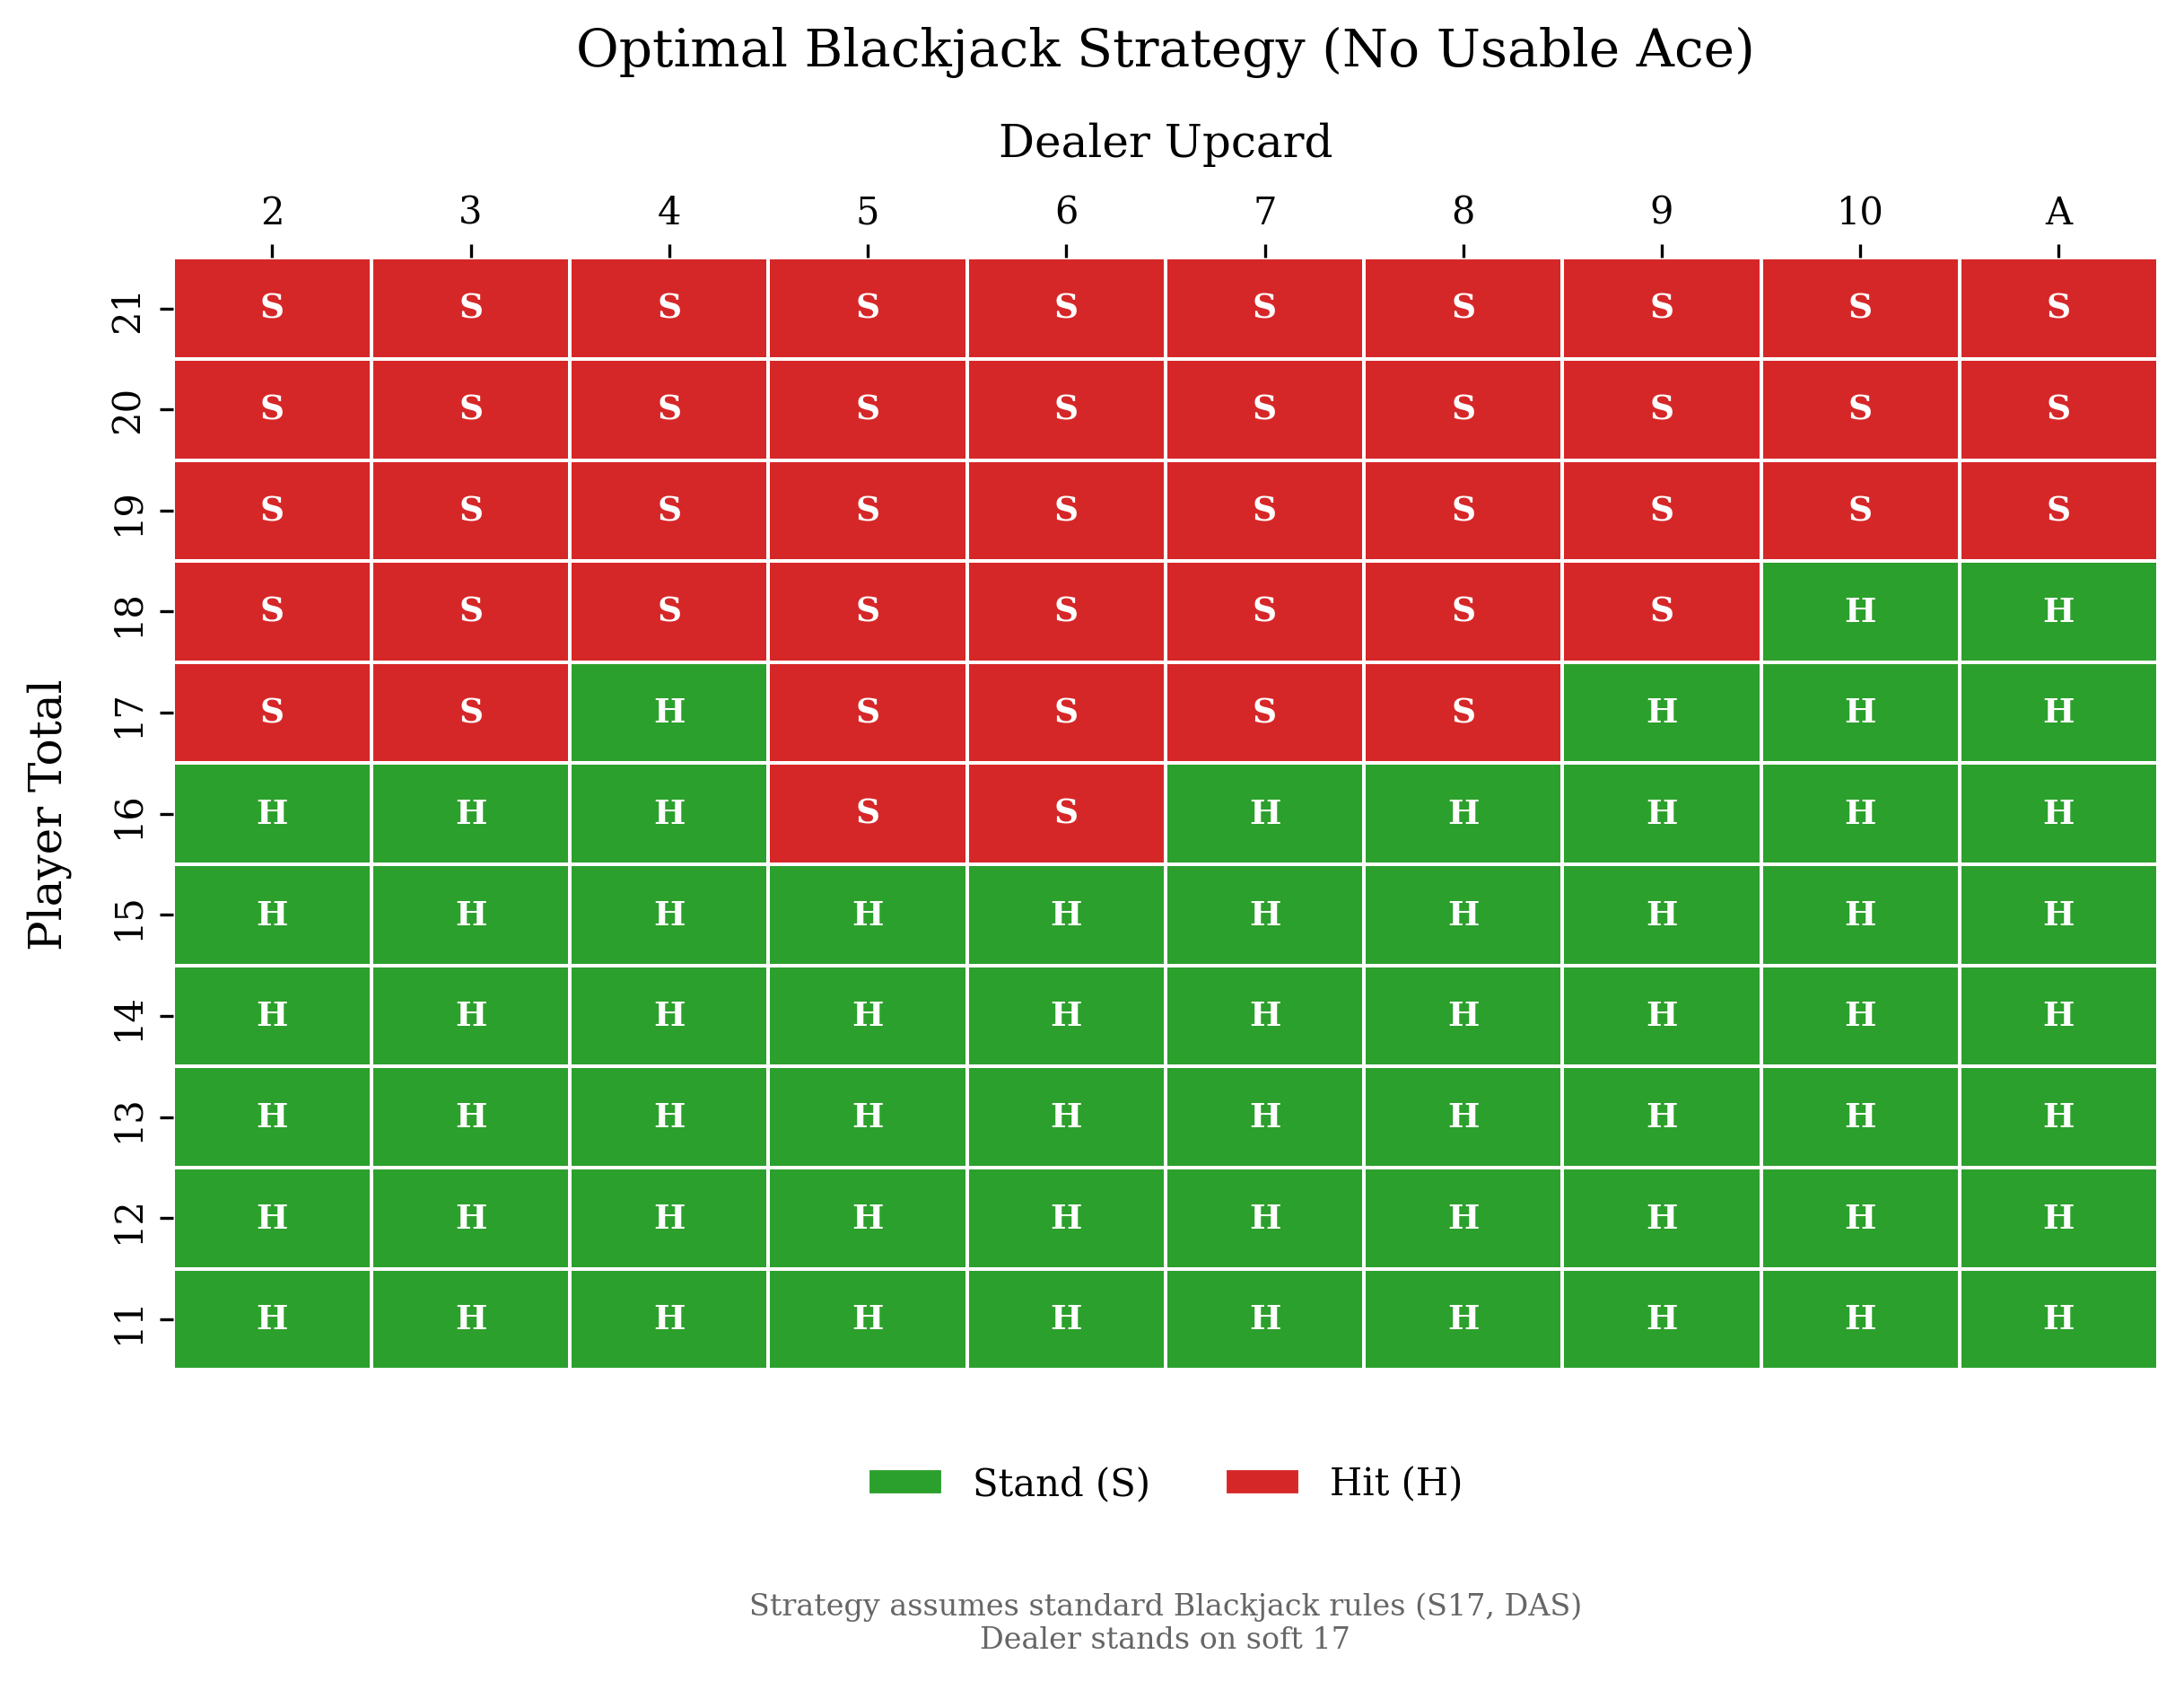

In [44]:
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

# Custom styling parameters
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'font.family': 'serif'
})

# Create figure with constrained layout
fig = plt.figure(figsize=(8, 6), dpi=300, layout='constrained')
ax = fig.add_subplot(111)

# Create custom colormap - CORRECTED SYNTAX
cmap = mcolors.ListedColormap(['#d62728', '#2ca02c'])  # Green for hit, red for stand
annot_df = policy.replace({0.0: 'S', 1.0: 'H'})

# Enhanced heatmap with styling
sns.heatmap(
    policy,
    cmap=cmap,
    annot=annot_df,
    fmt='',
    cbar=False,
    linewidths=0.5,
    linecolor='white',
    annot_kws={'fontsize': 9, 'color': 'white', 'weight': 'bold'},
    ax=ax
)


# Axis formatting
ax.set_xlabel("Dealer Upcard", labelpad=10)
ax.set_ylabel("Player Total", labelpad=10)
ax.set_title("Optimal Blackjack Strategy (No Usable Ace)", pad=15)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

# Custom legend
legend_elements = [
    Patch(facecolor='#2ca02c', edgecolor='white', label='Stand (S)'),
    Patch(facecolor='#d62728', edgecolor='white', label='Hit (H)')
]
ax.legend(
    handles=legend_elements,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False,
    fontsize=10
)

# Contextual annotation
ax.text(
    0.5, -0.25, 
    "Strategy assumes standard Blackjack rules (S17, DAS)\nDealer stands on soft 17",
    transform=ax.transAxes,
    ha='center',
    fontsize=8,
    color='#666666'
)

# Adjust layout and save
plt.show()

In [ ]:
# Evaluation phase
won = 0
n_eval_episodes = 960_400

# Create a fresh environment for evaluation (without wrappers)
eval_env = gym.make("Blackjack-v1", sab=True)

for _ in tqdm(range(n_eval_episodes)):
    obs, info = eval_env.reset()
    done = False
    while not done:
        # Convert observation using agent's method and add batch dimension
        state_tensor = agent._state_to_tensor(obs).unsqueeze(0)
        
        # Get action from policy network (no epsilon exploration)
        with torch.no_grad():
            q_values = agent.policy_net(state_tensor)
            action = q_values.argmax().item()
            
        obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated
        
    if reward == 1:  # Count only wins (draws have reward 0)
        won += 1

print(f"Win rate: {(won / n_eval_episodes) * 100:.2f}%")

100%|██████████| 10000000/10000000 [2:54:55<00:00, 952.76it/s]  


Win rate: 42.79%
